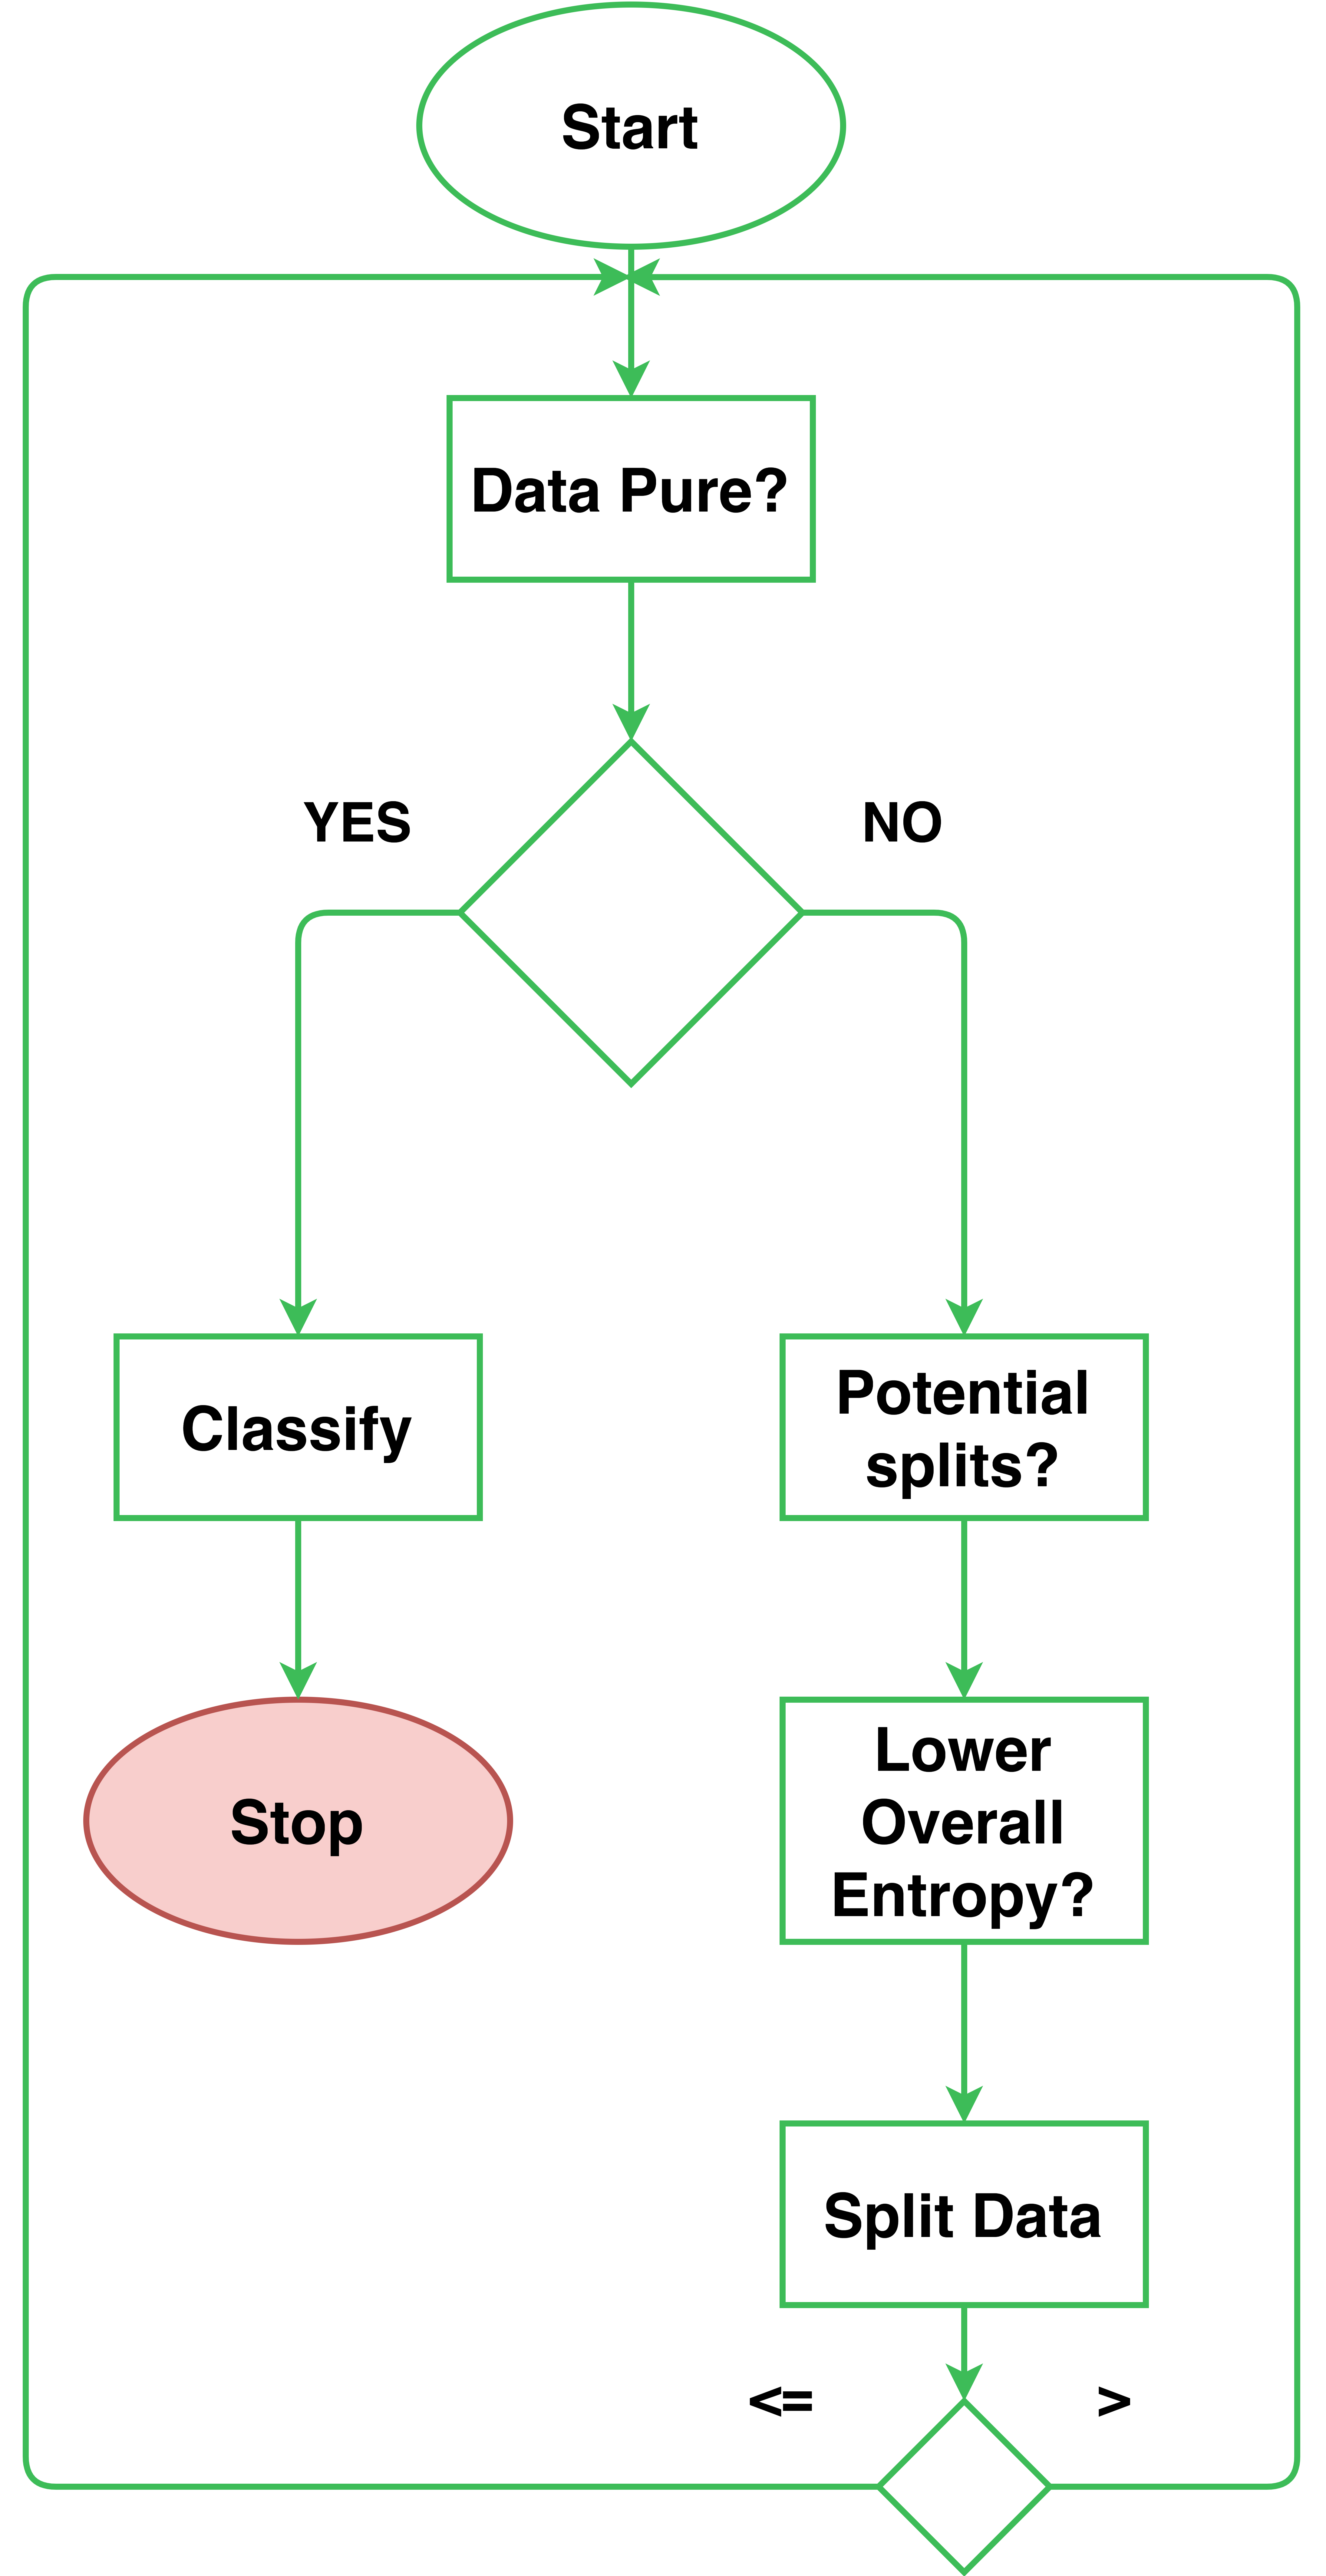

In [248]:
#### algorithm architecture
from IPython.display import Image
Image("algorithm_architecture.png",width=300)

In [249]:
# %pip install seaborn

#### Imports

In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
## to make sure that tree that we create is displayed in perty ways..
from pprint import pprint


#### Load Data

In [251]:
df = pd.read_csv("mini_dataset.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Prepare data

In [252]:
df["label"] = df.isFraud
df = df.drop(["isFraud", "step", "nameOrig", "nameDest", "isFlaggedFraud"], axis=1)

In [253]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,label
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [254]:
df.columns

Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'label'],
      dtype='object')

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            4999 non-null   object 
 1   amount          4999 non-null   float64
 2   oldbalanceOrg   4999 non-null   float64
 3   newbalanceOrig  4999 non-null   float64
 4   oldbalanceDest  4999 non-null   float64
 5   newbalanceDest  4999 non-null   float64
 6   label           4999 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 273.5+ KB


### Train Test Data
This function will help us to split our dataset

In [256]:
def train_test_split(df, test_size):
    if isinstance(test_size, float):
        test_size = int(test_size * len(df))
    indices = df.index.to_list()
    test_indices = random.sample(population=indices,k=test_size)
    test_df = df.loc[indices]
    train_df = df.drop(test_indices) # drop test data
    return train_df,test_df

In [257]:
random.seed(0) # to make sure we got the same random numbers everytime
train_df, test_df = train_test_split(df,0.2)
train_df.values[:5]

array([['CASH_OUT', 181.0, 181.0, 0.0, 21182.0, 0.0, 1],
       ['PAYMENT', 11668.14, 41554.0, 29885.86, 0.0, 0.0, 0],
       ['PAYMENT', 7817.71, 53860.0, 46042.29, 0.0, 0.0, 0],
       ['PAYMENT', 7107.77, 183195.0, 176087.23, 0.0, 0.0, 0],
       ['PAYMENT', 7861.64, 176087.23, 168225.59, 0.0, 0.0, 0]],
      dtype=object)

### Helper Functions

####  Determine type of feature
This function will return an array that contains type of each feature (categorical or continuous) in each index, so we can use after for making our algorithm work on numerical and categorical data.

In [258]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [259]:
FEATURE_TYPES = determine_type_of_feature(df)
FEATURE_TYPES

['categorical',
 'continuous',
 'continuous',
 'continuous',
 'continuous',
 'continuous']

##### Data Pure?
This function will help us to verify if the data passed is pure, that mean is they are only one class.

In [260]:
def check_purity(data):
    label_column = data[:,-1]
    unique_classes = np.unique(label_column)
    return len(unique_classes) == 1

In [261]:
check_purity(train_df.values)

False

#### Classify
This function will return the best class for given data

In [262]:
def classify(data):
    label_column = data[:,-1]
    unique_classes, count_unique_classes = np.unique(label_column, return_counts=True)
    index_max_count_unique_classes = count_unique_classes.argmax()
    return unique_classes[index_max_count_unique_classes]

In [263]:
classify(train_df.values)

0

#### Potential splits?
This function will return dictionary of possible pentantial splits that can split data on, each key in dictionary is index of feature in our dataset

In [264]:
def get_pentantial_split(data):
    pentantial_splits = {}
    nbr_columns = data.shape[1] -1 # exclude the label
    for column_index in range(nbr_columns):
        
        current_columns_values = data[:,column_index]
        unique_values = np.unique(current_columns_values)
        
        if FEATURE_TYPES[column_index] == "continuous":
            pentantial_splits[column_index] = []
            for index in range(1,len(unique_values)):
                prev_value = unique_values[index -1]
                curr_value = unique_values[index]
                pentantial_split = (float(prev_value) + float(curr_value))/2
                pentantial_splits[column_index].append(pentantial_split)
                
        else:
            pentantial_splits[column_index] = unique_values
    
    return pentantial_splits
    

In [265]:
pentantial_splis = get_pentantial_split(train_df.values)
pentantial_splis

{0: array(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'],
       dtype=object),
 1: [6.675,
  10.235,
  14.3,
  19.185,
  24.215,
  26.335,
  28.29,
  31.625,
  34.71,
  36.67,
  38.4,
  38.769999999999996,
  42.88,
  49.730000000000004,
  55.394999999999996,
  59.945,
  65.315,
  69.715,
  74.87,
  79.405,
  81.88499999999999,
  84.82,
  88.89500000000001,
  97.37,
  104.59,
  111.12,
  116.375,
  124.86999999999999,
  135.14999999999998,
  138.555,
  140.13,
  141.45,
  145.765,
  149.865,
  150.20999999999998,
  150.77499999999998,
  153.035,
  156.39,
  160.04,
  162.21499999999997,
  162.29,
  163.01999999999998,
  172.36,
  181.435,
  184.10000000000002,
  189.03,
  193.065,
  195.065,
  196.245,
  198.615,
  202.865,
  207.22,
  211.265,
  219.82,
  229.515,
  233.25,
  238.925,
  245.825,
  254.755,
  263.44,
  265.065,
  265.5,
  266.86,
  269.62,
  272.06,
  275.685,
  279.205,
  280.215,
  281.505,
  287.435,
  296.43,
  302.015,
  305.685,
  308.53999999999996,
  3

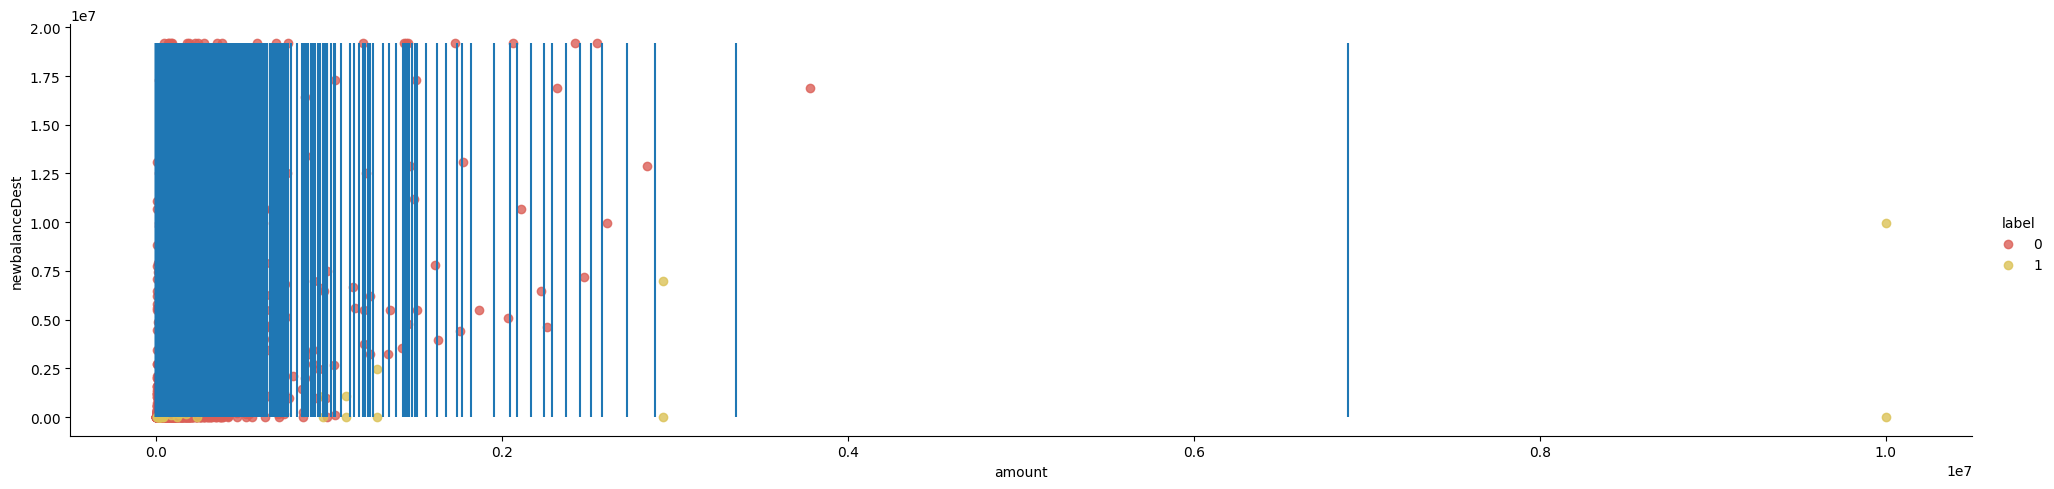

In [266]:
palette = sns.color_palette("hls", 8)
sns.lmplot(train_df,x="amount",y="newbalanceDest", hue="label",fit_reg=False,aspect=4,palette=palette)
y_max = max(test_df["newbalanceDest"].values)
plt.vlines(x=pentantial_splis[1], ymin=0 ,ymax=y_max)
# x_max = max(test_df["amount"].values)
# plt.hlines(y=pentantial_splis[0],xmin=0,xmax=x_max)

### Split Data
This function will split data based on feature and split value

In [267]:
def split_data(m_data,split_column,split_value):
    split_column_values = m_data[:,split_column]
    if FEATURE_TYPES[split_column] == "continuous":
        data_below = m_data[split_column_values <= split_value]
        data_above  = m_data[split_column_values > split_value]
    else:
        data_below = m_data[split_column_values == split_value]
        data_above  = m_data[split_column_values != split_value]
    return data_below, data_above
    

In [268]:
data_below,data_above = split_data(train_df.values,1,0.8)
data_above

array([['CASH_OUT', 181.0, 181.0, ..., 21182.0, 0.0, 1],
       ['PAYMENT', 11668.14, 41554.0, ..., 0.0, 0.0, 0],
       ['PAYMENT', 7817.71, 53860.0, ..., 0.0, 0.0, 0],
       ...,
       ['CASH_IN', 78588.13, 3678275.07, ..., 955069.95, 876481.82, 0],
       ['CASH_IN', 185680.98, 3756863.21, ..., 1774746.94, 1589065.96, 0],
       ['CASH_IN', 122744.28, 4009561.32, ..., 207106.34, 84362.06, 0]],
      dtype=object)

### Lowest Overall Entropy

In [269]:
def calculate_entropy(m_data):
    
    lable_column = m_data[:,-1] #get label column
    _, counts = np.unique(lable_column, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = sum(probabilities *- np.log2(probabilities))# with numpy is easy 
    return entropy

In [270]:
calculate_entropy(data_above)

0.07067637446155645

In [271]:
def caculate_overall_entropy(data_below,data_above):
    
    n_data_points = len(data_below) + len(data_above)
    p_data_below = len(data_below)/n_data_points;
    p_data_above= len(data_above)/n_data_points;
    overall_entropy = (p_data_below * calculate_entropy(data_below)) + (p_data_above * calculate_entropy(data_above))
    return overall_entropy
    

In [272]:
caculate_overall_entropy(data_below,data_above)

0.07067637446155645

In [273]:
def determine_best_split(data,pentantial_splits):
    overall_entropy = 999
    for column_index in pentantial_splits:
        for value in pentantial_splits[column_index]:
            data_below,data_above = split_data(data,split_column=column_index,split_value=value)
            current_overall_entropy = caculate_overall_entropy(data_below,data_above)
            if(current_overall_entropy <= overall_entropy):
                overall_entropy = current_overall_entropy
                best_split_column,best_split_value=(column_index,value)
    return best_split_column,best_split_value

In [274]:

determine_best_split(train_df.values,get_pentantial_split(train_df.values))

(3, 2.915)

## Decision Tree Algorithm
The key will be the question and value will be list of two element yes answer and no answer <br>
{"patel_width <= 2.5":["the_class",{""or onthoer dictionary..""}]}

## Algorithm

In [275]:
def decision_tree_alorithm(df, counter = 0):
    if counter == 0:
        data = df.values
        global column_headers
        column_headers = df.columns
    else:
        data = df
        
    # base case
    if check_purity(data):
        classification = classify(data)
        return classification
    else:
        #recursive part
        counter += 1
        pentantial_splits = get_pentantial_split(data)
        split_column, split_value = determine_best_split(data,pentantial_splits)
        data_below,data_above = split_data(data,split_column,split_value)
        # instantiate sub-tree
        feature_name = column_headers[split_column]
        if FEATURE_TYPES[split_column] == "continuous":
            question = "{} <= {}".format(feature_name,split_value)
        else:
            question = "{} == {}".format(feature_name,split_value)
        sub_tree = {question:[]}
        # finds answers 
        yes_answer = decision_tree_alorithm(data_below, counter)
        no_answer = decision_tree_alorithm(data_above, counter)
        
        # append subs
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [276]:
tree = decision_tree_alorithm(train_df)
tree

{'newbalanceOrig <= 2.915': [{'oldbalanceOrg <= 10538.685000000001': [{'type == CASH_OUT': [{'oldbalanceDest <= 26759.415': [{'amount <= 132612.605': [{'amount <= 4014.985': [{'oldbalanceDest <= 17649.0': [0,
              1]},
            0]},
          {'amount <= 467987.645': [1, 0]}]},
        0]},
      0]},
    {'oldbalanceOrg <= 224343.83000000002': [{'amount <= 35712.485': [{'type == PAYMENT': [0,
          {'oldbalanceDest <= 21951.895': [1,
            {'oldbalanceOrg <= 17597.445': [0,
              {'newbalanceDest <= 3418904.965': [{'newbalanceDest <= 3775.015': [0,
                  1]},
                0]}]}]}]},
        {'oldbalanceDest <= 27.5': [{'oldbalanceOrg <= 81068.58499999999': [0,
            {'amount <= 130235.695': [1,
              {'oldbalanceOrg <= 146531.865': [0, 1]}]}]},
          0]}]},
      {'oldbalanceDest <= 5439783.36': [1, 0]}]}]},
  {'oldbalanceOrg <= 12750000.0': [0, 1]}]}

#### To view the tree we can use this website: https://jsoncrack.com/editor but first we need to replace all ' with "" to make a validate JSON format so we can use this website: http://www.unit-conversion.info/texttools/replace-text/

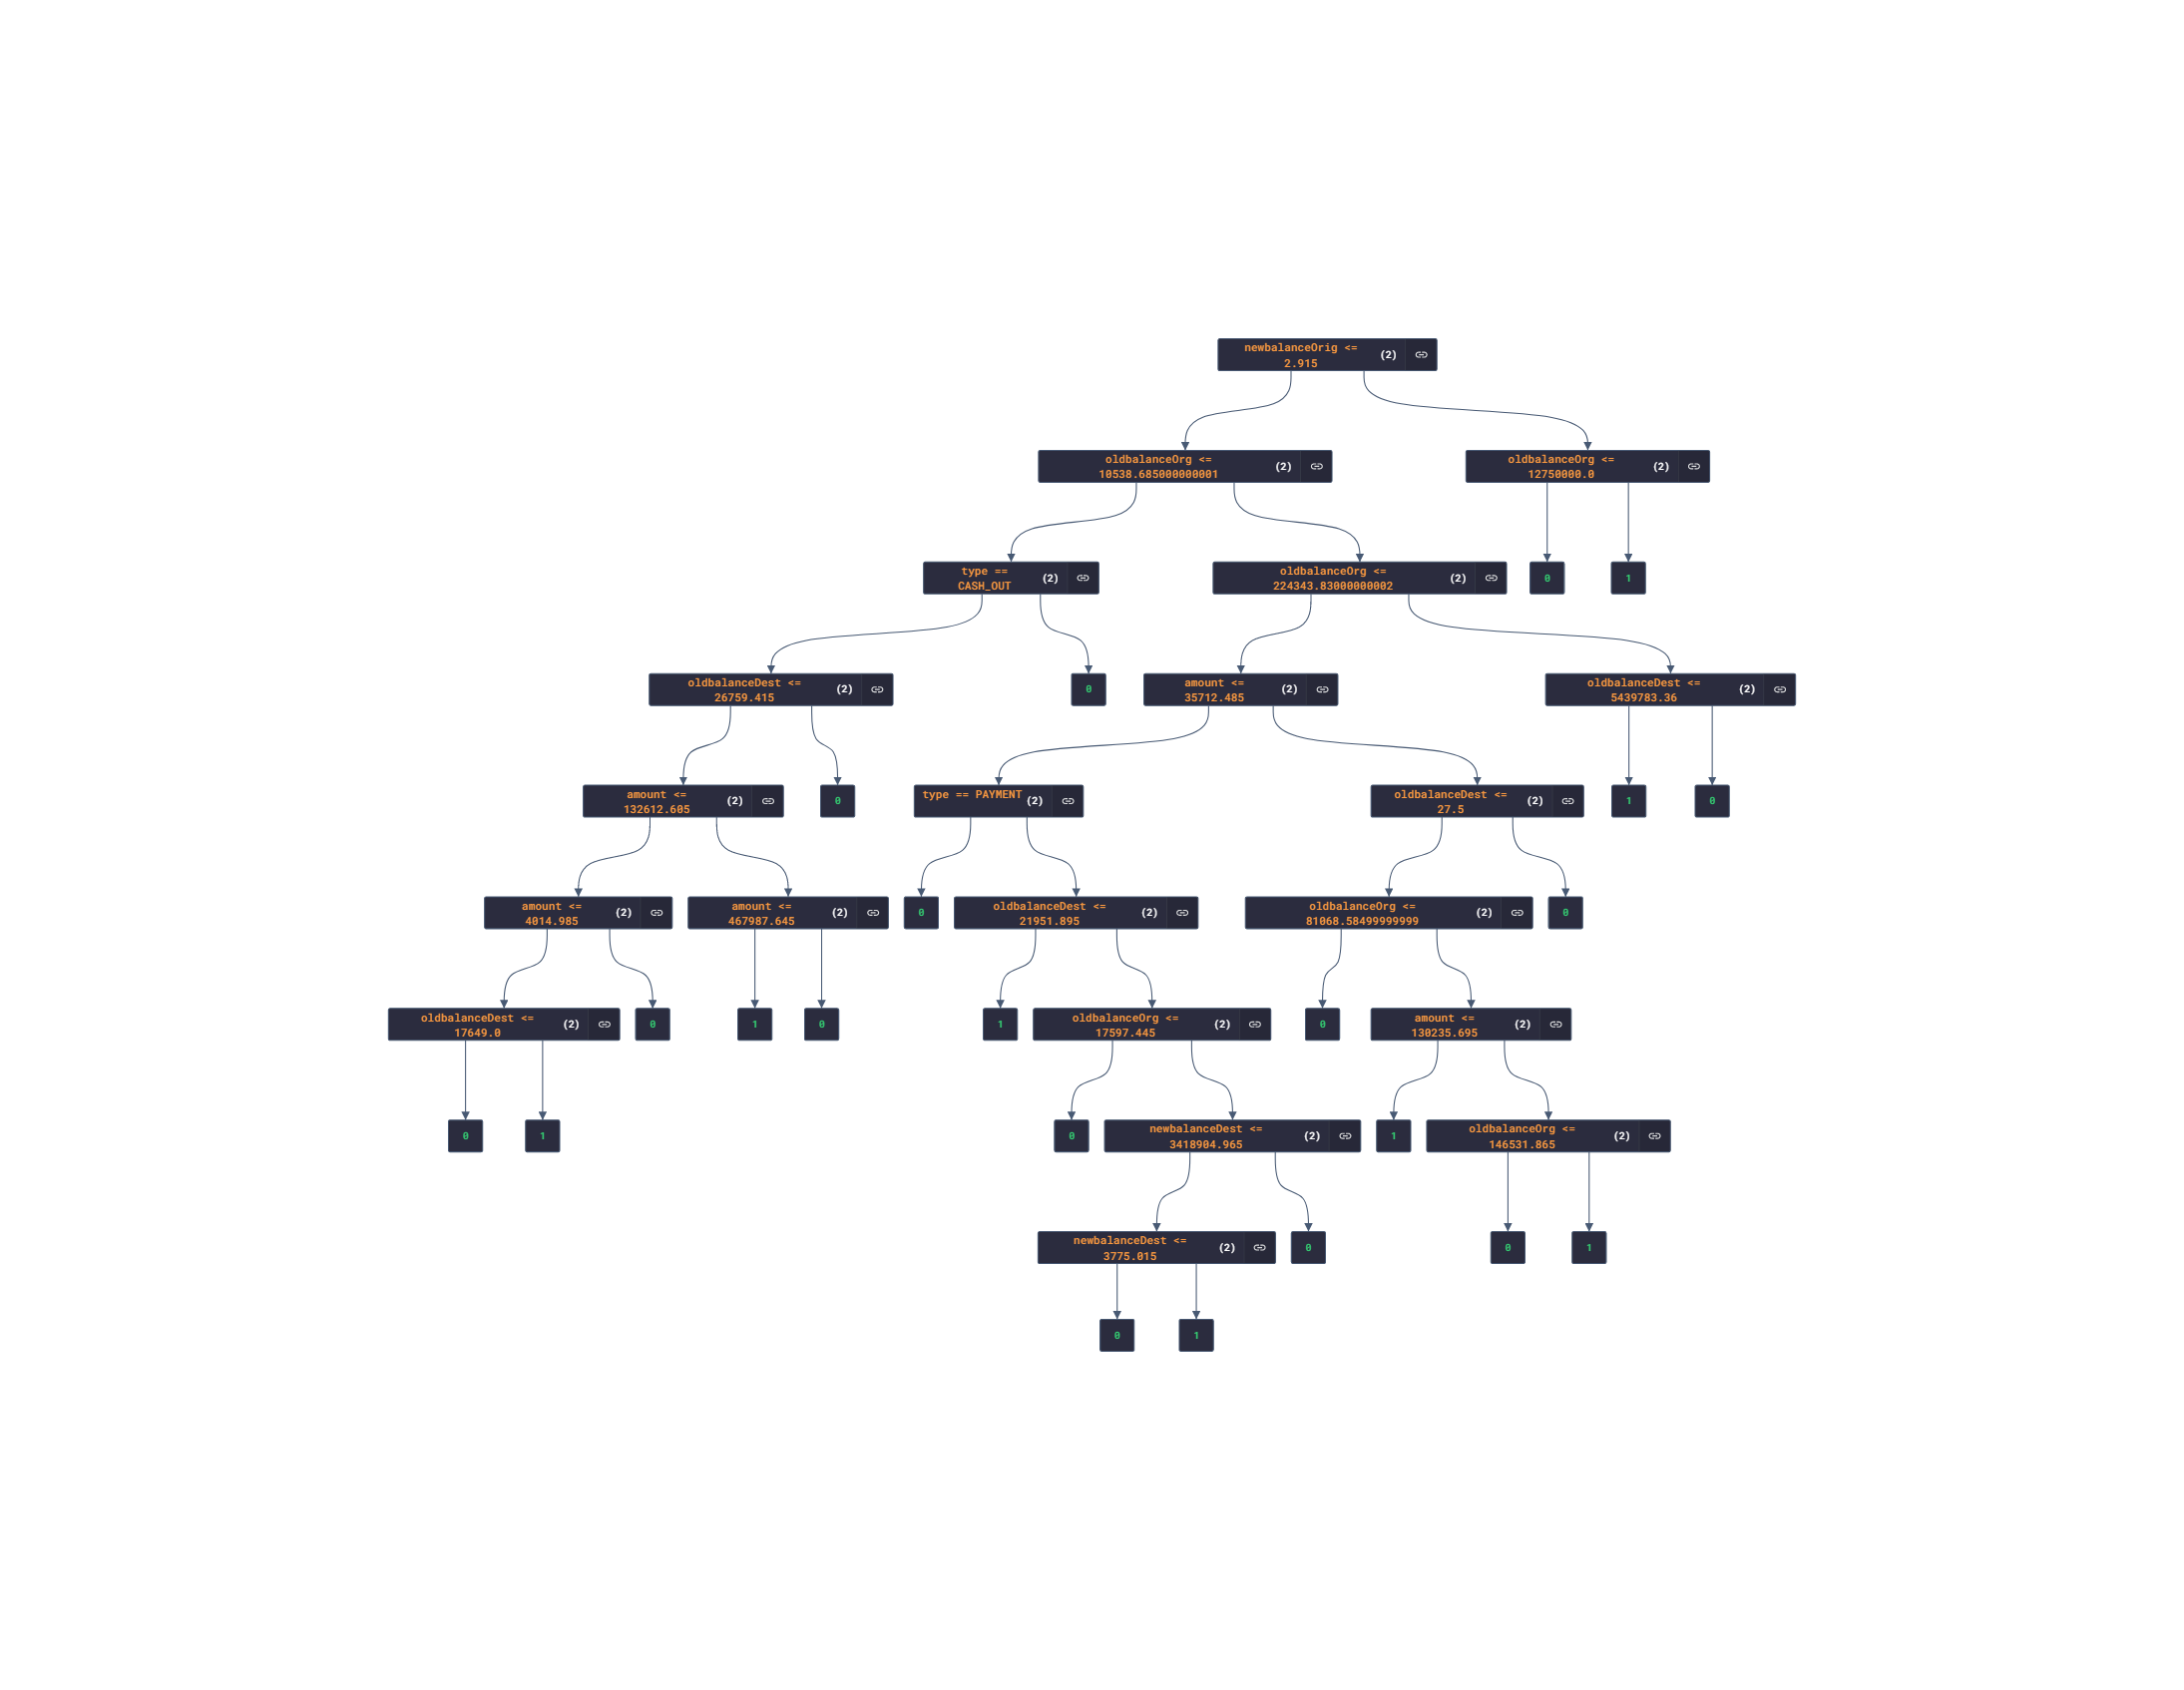

In [277]:
Image(filename='result_tree.png')

# Classification

In [278]:
example_0 = test_df.iloc[109]

In [279]:
def classify_example(example,tree):
    question = list(tree.keys())[0]
    
    feature_name, comparison_operator, value = question.split()
    
    if comparison_operator == "<=":
        if(example[feature_name] <= float(value)):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    else:
        if(example[feature_name] == value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer,dict):
        return answer
    else:
        residual_tree = answer
        return classify_example(example,residual_tree)

In [280]:
classify_example(example_0,tree)


0

### Accuracy

In [281]:
def calculate_accuracy(df,tree):
    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["label"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

In [282]:
accuracy = calculate_accuracy(test_df, tree)
accuracy

0.9985997199439888